In [ ]:
# https://youtu.be/XyX5HNuv-xE

In [17]:
# Create masks of SEM images using the annotation tool 
# Iterate through and change masks to binary

from scipy import ndimage, misc
import numpy as np
import os
import cv2
import imageio.v2 as imageio

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

def main():
    outPath = "C:/Users/lucyh/Desktop/Images/Filopodia/grey/"
    path = "C:/Users/lucyh/Desktop/Images/Filopodia/masks/"

    # iterate through the mask images of the folder
    for image_path in os.listdir(path):

        # create the full input path and read the image
        input_path = os.path.join(path, image_path)
        image_to_mask = imageio.imread(input_path)
        
        # normalize
        norm_image = cv2.normalize(image_to_mask, None, alpha = 0, beta = 2, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        norm_image = norm_image.astype(np.uint8)

        # change masks to binary 
        red = norm_image[:, :, 0]
        green = norm_image[:, :, 1]
        blue = norm_image[:, :, 2]
        binary = (0.299 * red / 255 + 0.587 * green / 255 + 0.114 * blue / 255)

        # create full output path, 'example.jpg' 
        # becomes 'rotate_example.jpg', save the file to disk
        fullpath = os.path.join(outPath, 'binary_'+image_path)
        imageio.imwrite(fullpath, binary)

if __name__ == '__main__':
    main()

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [12]:
from simple_multi_unet_model import multi_unet_model 

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [13]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=3 #Number of classes for segmentation


In [45]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("C:/Users/lucyh/Desktop/Images/Filopodia/images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

#Convert list to array for machine learning processing        
train_images = np.array(train_images, dtype=float)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("C:/Users/lucyh/Desktop/Images/Filopodia/grey/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

#Convert list to array for machine learning processing          
train_masks = np.array(train_masks, dtype=float)


In [46]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped.ravel())
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


array([0, 1, 2], dtype=int64)

In [47]:
train_images = np.expand_dims(train_images, axis=3)
train_images = train_images.astype(float)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)


In [48]:
#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks, test_size = 0.10, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0. 1. 2.]


In [49]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2],X_test.shape[3]))

In [50]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [51]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_masks_reshaped_encoded),
                                        y = train_masks_reshaped_encoded                                                    
                                    )
class_weights = dict(zip(np.unique(train_masks_reshaped_encoded), class_weights))
class_weights


{0: 0.626400881073568, 1: 2.5015834864283146, 2: 0.9961831911346475}

In [52]:
# load model 
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

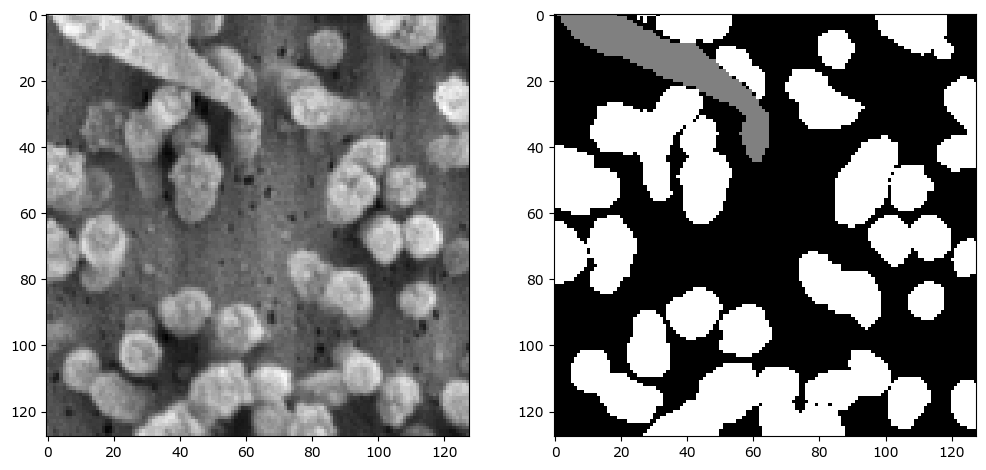

In [53]:
#Sanity check, see if masks correspond to images
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number], cmap='gray')
plt.show()

In [54]:
# train model
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

model.save('multiclass.hdf5')


Epoch 1/200
6/6 [==============================] - 16s 2s/step - loss: 1.0584 - accuracy: 0.4463 - val_loss: 1.0407 - val_accuracy: 0.5292
Epoch 2/200
6/6 [==============================] - 11s 2s/step - loss: 1.0115 - accuracy: 0.5296 - val_loss: 1.0225 - val_accuracy: 0.5291
Epoch 3/200
6/6 [==============================] - 14s 2s/step - loss: 1.0018 - accuracy: 0.5341 - val_loss: 1.0138 - val_accuracy: 0.5311
Epoch 4/200
6/6 [==============================] - 11s 2s/step - loss: 0.9787 - accuracy: 0.5370 - val_loss: 0.9741 - val_accuracy: 0.5314
Epoch 5/200
6/6 [==============================] - 12s 2s/step - loss: 0.9456 - accuracy: 0.5796 - val_loss: 0.9096 - val_accuracy: 0.5586
Epoch 6/200
6/6 [==============================] - 11s 2s/step - loss: 0.8935 - accuracy: 0.6231 - val_loss: 0.8715 - val_accuracy: 0.6223
Epoch 7/200
6/6 [==============================] - 9s 1s/step - loss: 0.8334 - accuracy: 0.6550 - val_loss: 0.7945 - val_accuracy: 0.6744
Epoch 8/200
6/6 [===========

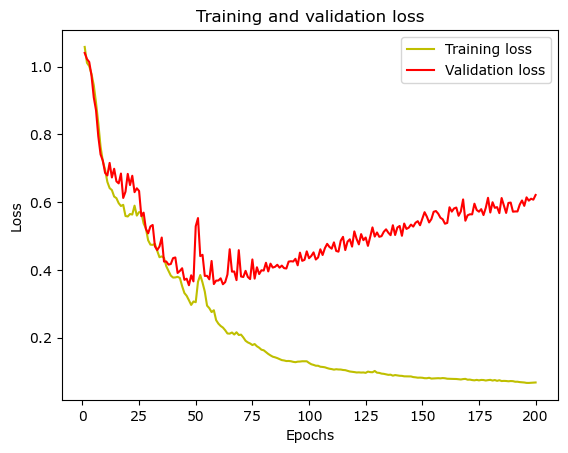

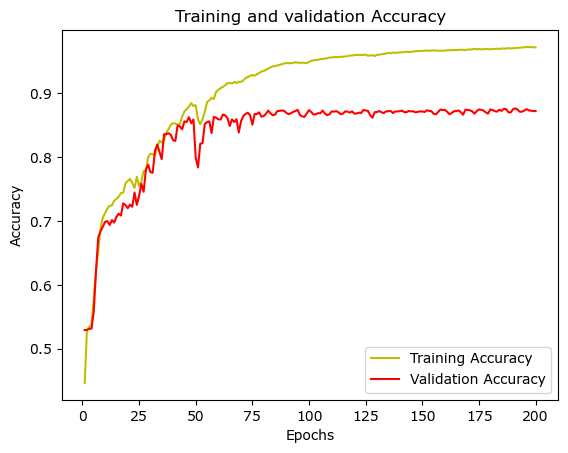

In [57]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [58]:
#model = get_model()
model.load_weights('multiclass.hdf5')  

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

1/1 [==============================] - 1s 527ms/step


Mean IoU = 0.7510732
[[77624.  2377.  6694.]
 [ 1590. 20177.  3131.]
 [ 5649.  1522. 45076.]]
IoU for class1 is:  0.82636744
IoU for class2 is:  0.70066327
IoU for class3 is:  0.72618896


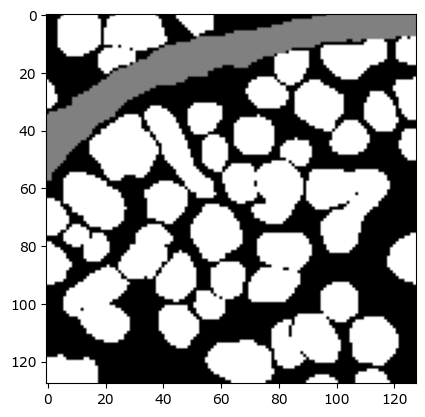

In [64]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)  

IOU_keras.update_state(y_test[:,:,:], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[0,1]+ values[2,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[0,2]+ values[1,2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')


1/1 [==============================] - 0s 51ms/step


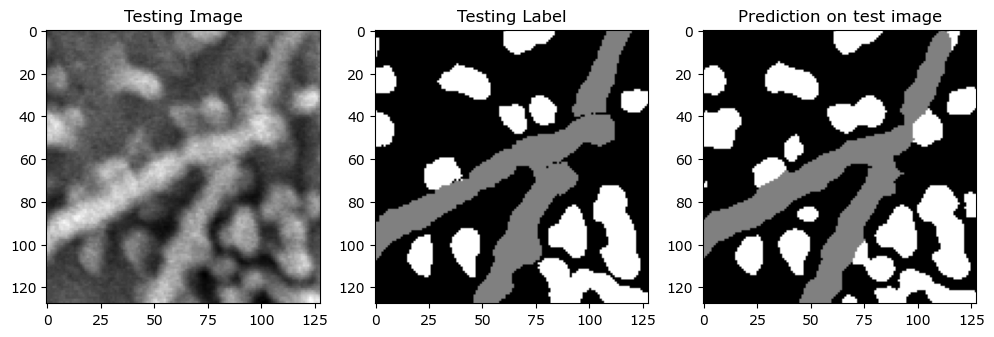

In [76]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()